# Manoeuvring simulations
Many simulation model for ship manoeuvring have been developed in the field of ship hydrodynamics such as: the Abkowitz model <cite id="abkowitz_ship_1964">[NO_PRINTED_FORM]</cite> or the Norrbin model {cite}`norrbin_study_1960`.
This chapter will develop a general simulation model for ship manoeuvring, that can be further specified to become either the Abkowitz or Norbin model. Expressing the models on a general form is important in this research where many different models will be tested and compared.

In [1]:
import matplotlib 
print(matplotlib.get_configdir())

C:\Users\maa\.matplotlib


In [2]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex, Markdown
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot
from src.equation import Equation

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_nonlinear_EOM  as vmm 

import matplotlib.pyplot as plt
if os.name == 'nt':
    plt.style.use('book.mplstyle')  # Windows

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/book.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/book.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Ship parameters
The Ocean Bird Wind Powered Car Carrier will be used as the reference ship of this book:
![](https://www.walleniusmarine.com/wp-content/uploads/2020/09/oceanbird-960x540.jpg)

In [3]:
ship_parameters ={'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

ps = prime_system.PrimeSystem(**ship_parameters)  # model

A model scale version of this ship has the following main dimensions:

In [4]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

## 3 DOF
A simulation model with only three degrees of fredom (DOF) : *surge*, *sway* and *yaw* is often sufficient to describe the ship's manoeuvring performance. The equation of motion can be expressed as <cite id="2k4ro">(Triantafyllou &#38; Hover, 2003)</cite>:

In [5]:
display(Math(vlatex(vmm.X_eom)))
display(Math(vlatex(vmm.Y_eom)))
display(Math(vlatex(vmm.N_eom)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Where $X_{force}$, $Y_{force}$ and $N_{force}$ are the hydrodynamic forces from the ship. So these equations holds for most of the different models for manoeuvring, except linear models where the nonlinear $r\cdot u$ term have been linearized. The difference in the methods is rather in how these hydrodynamic forces are calculated.

The hydrodynamic forces can be split into added masses (that depend on the accelerations: $\dot{u}$, $\dot{v}$, $\dot{r}$) and dampings (that depend on the velocities: $u$, $v$, $r$):

In [6]:
display(Math(vlatex(vmm.fx_eq)))
display(Math(vlatex(vmm.fy_eq)))
display(Math(vlatex(vmm.mz_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$X_{\dot{u}}$, $X_{\dot{v}}$, $X_{\dot{r}}$ are the added masses: when the ship is accelerating in water, not only the mass of the ship is accelerating, but also some mass in the water needs to be accelerated. This is referred to as added masses. Sometimes added  masses such as $X_{\dot{v}}$ is neglected, as in the case above.

The specialization of the various simulation models can now be further categorized to the functions to calculate the damping forces: $X_{qs}$, $Y_{qs}$, $N_{qs}$. The subscript "qs" stands for quasi static.

In [7]:
ship_parameters_prime = ps.prime(ship_parameters)

The general equation for all of the simulation models in this research can be written as: 

In [8]:
display(Math(vlatex(vmm.X_eq)))
display(Math(vlatex(vmm.Y_eq)))
display(Math(vlatex(vmm.N_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The classic simulation methods express the damping forces as a truncated taylor series. Here is a rather simple model, that has been created by the author to be used in the followin examples.

In [9]:
display(Math(vlatex(vmm.X_qs_eq)))
display(Math(vlatex(vmm.Y_qs_eq)))
display(Math(vlatex(vmm.N_qs_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Similitude

### Prime system
The prime system uses ship length $L$, water density $\rho$ and total velocity $U^2=u^2+v^2$ to express physical quantities in nondimensional form. The quantities have a prime symbol (') attached to them when the prime system is used. The quantities are made nondimensional with the prime system by dividing with a denominator according to the table below:

In [10]:
prime_system.df_prime.loc[['denominator']].transpose()

,denominator
length,L
volume,L**3
mass,0.5*L**3*rho
density,0.5*rho
inertia_moment,0.5*L**5*rho
time,L/U
area,L**2
angle,1
-,1
linear_velocity,U


The manoeuvring models are often expressed in the prime system so that a nondimensional force $F'$ for instance can be expressed as a function of some coefficients $C$ and nondimensional velocity $v$:

In [11]:
F_,v_, C_=sp.symbols("F' v' C")
F=sp.symbols("F")

eq = sp.Eq(F_, 
      C_*v_)
eq

Eq(F', C*v')

This may look as a model where the force depend on the transverse velocity $v$ only, but this is actually not true. If this equation is converted converted back to SI units it is instead written:

In [12]:
eq_F_prime = sp.Eq(F,prime_system.df_prime.loc['denominator','force']*F_)
eq_v_prime = sp.Eq(v,prime_system.df_prime.loc['denominator','linear_velocity']*v_)

eqs = [eq, eq_F_prime, eq_v_prime]

sp.Eq(F,sp.solve(eqs,F,F_,v_,dict=True)[0][F])

Eq(F, 0.5*C*L**2*U*rho*v(t))

So it is now clear that the example force model above, also depends on the total velocity $U$. 

## Brix parameters
The hydrodynamic derivatives can be estimated with semi empirical formulas according to <cite id="ycziw">(Brix, 1993)</cite>.

In [13]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

#df_parameters['brix_prime'].fillna(0, inplace=True)


In [14]:
df_parameters['prime'] = df_parameters['brix_prime']

df_parameters.loc['Ydelta','prime'] = 0.001  # Just guessing
df_parameters.loc['Ndelta','prime'] = -df_parameters.loc['Ydelta','prime']/2  # Just guessing
#df_parameters['prime'].fillna(0, inplace=True)

In [15]:
df_parameters.loc['Nu','prime'] = 0
df_parameters.loc['Nur','prime'] = 0
df_parameters.loc['Xdelta','prime'] = 0
df_parameters.loc['Xr','prime'] = 0
df_parameters.loc['Xrr','prime'] = 0
df_parameters.loc['Xu','prime'] = 0
df_parameters.loc['Xv','prime'] = 0
df_parameters.loc['Xvr','prime'] = -0.006
df_parameters.loc['Yu','prime'] = 0
df_parameters.loc['Yur','prime'] = 0

In [16]:
mask = df_parameters['prime'].notnull()
index = df_parameters.loc[mask,'prime'].index
coefficients=vmm.simulator.get_all_coefficients(sympy_symbols=False)
missing_coefficients = set(coefficients) - set(index)
missing_coefficients

set()

In [17]:
mask = df_parameters['prime'].notnull()
for index, parameter in df_parameters.loc[mask].iterrows():
    display(sp.Eq(parameter['symbol'],parameter['prime']))

Eq(X_{\dot{u}}, 0.00017880704448812)

Eq(Y_{\dot{v}}, -0.00610938740826336)

Eq(Y_{\dot{r}}, -0.000303137774581419)

Eq(N_{\dot{v}}, -0.000128254401723757)

Eq(N_{\dot{r}}, -0.000298674827731788)

Eq(X_{u}, 0.0)

Eq(X_{v}, 0.0)

Eq(X_{r}, 0.0)

Eq(X_{delta}, 0.0)

Eq(X_{vr}, -0.006)

Eq(X_{rr}, 0.0)

Eq(Y_{u}, 0.0)

Eq(Y_{v}, -0.00971290834761524)

Eq(Y_{r}, 0.00240236113642936)

Eq(Y_{delta}, 0.001)

Eq(Y_{ur}, 0.0)

Eq(N_{u}, 0.0)

Eq(N_{v}, -0.00318395170922333)

Eq(N_{r}, -0.00171885123535641)

Eq(N_{delta}, -0.0005)

Eq(N_{ur}, 0.0)

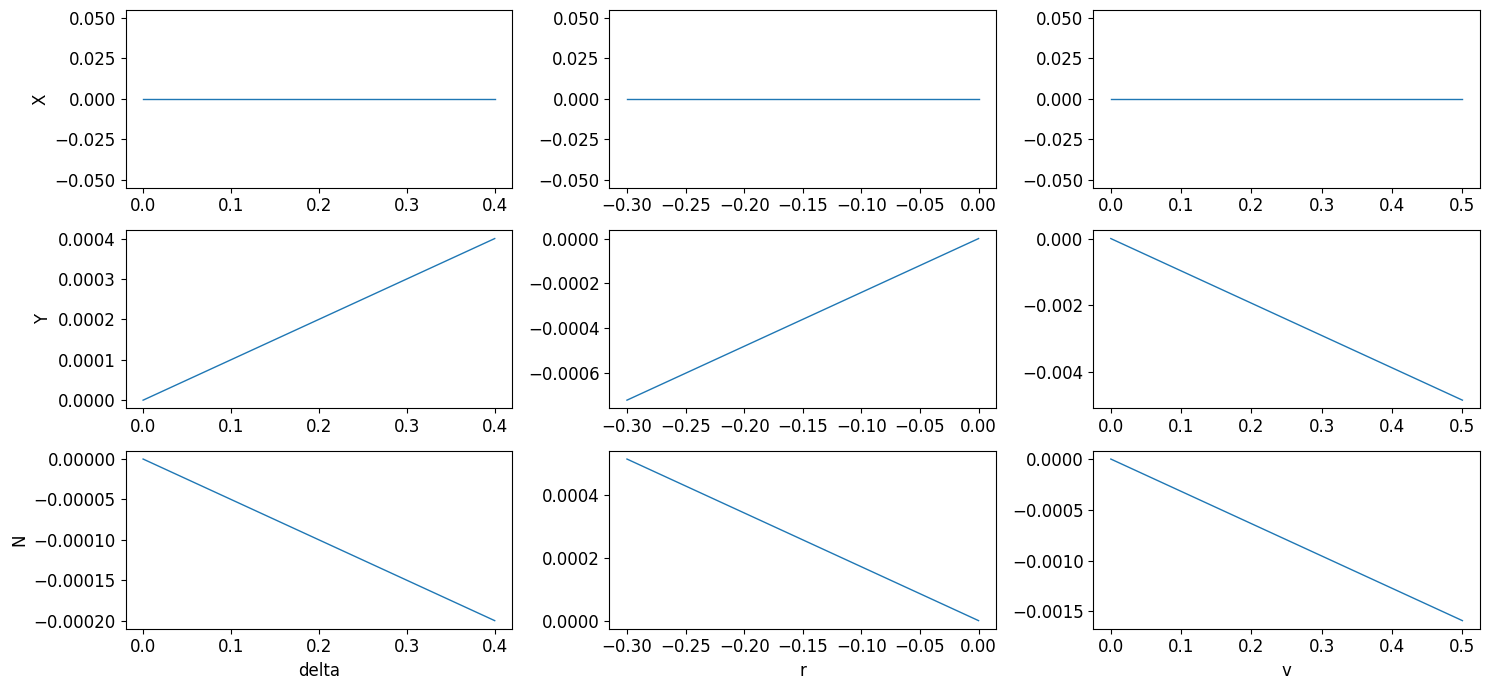

In [40]:
parameters=df_parameters['prime'].copy()

N_=30
df_captive_template = pd.DataFrame(index=np.arange(N_))
U_ = 2
df_captive_template['U'] = U_
df_captive_template['u'] = df_captive_template['U']
df_captive_template['v'] = 0
df_captive_template['r'] = 0
df_captive_template['delta'] = 0

df_r = df_captive_template.copy()
df_r['r'] = np.linspace(-0.3,0,N_)
df_r['vary'] = 'r'

df_v = df_captive_template.copy()
df_v['v'] = np.linspace(0,0.5,N_)
df_v['u'] = np.sqrt(df_v['U']**2 - df_v['v']**2)
df_v['vary'] = 'v'

df_delta = df_captive_template.copy()
df_delta['delta'] = np.linspace(0.,0.4,N_)
df_delta['vary'] = 'delta'

df_captive = pd.concat([df_delta,df_v,df_r])

df_captive['X'] = run(vmm.simulator.X_qs_lambda, inputs=parameters, **df_captive)
df_captive['Y'] = run(vmm.simulator.Y_qs_lambda, inputs=parameters, **df_captive)
df_captive['N'] = run(vmm.simulator.N_qs_lambda, inputs=parameters, **df_captive)

ncols = len(df_captive['vary'].unique())
fig,axes=plt.subplots(ncols=ncols, nrows=3)


for col,(vary, df_) in enumerate(df_captive.groupby(by='vary')):
    
    for row,dof in enumerate(['X','Y','N']):
        ax = axes[row,col]
        df_.plot(x=vary, y=dof, ax=ax)
        ax.get_legend().set_visible(False)
        ax.set_xlabel('')
        
        axes[row,0].set_ylabel(dof)
        
    axes[-1,col].set_xlabel(vary)

In [45]:
Markdown(f"""The figure above shows the quasi static forces for the present ship with the hydrodynamic derivatives during a variation of rudder angle $\delta$,
         yaw rate $r$ and tranverse velocity $v$ and total velocity $U$={U_} m/s""") 

The figure above shows the quasi static forces for the present ship with the hydrodynamic derivatives during a variation of rudder angle $\delta$,
         yaw rate $r$ and tranverse velocity $v$ and total velocity $U$=2 m/s

## Simulation

### Decoupling
There is a coupling between the sway and yaw equation thruogh the added masses. These equations need to be decoupled to be usable in a simulation model. This is done by first expressing the equation in matrix form:

In [19]:
A = vmm.simulator.A
b = vmm.simulator.b
acceleration = sp.matrices.MutableDenseMatrix([u.diff(),v.diff(),r.diff()])
eq_simulator = sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(b))
Math(vlatex(eq_simulator))

<IPython.core.display.Math object>

The decoupled equations are obtained by inverting the intertia matrix:

In [20]:
Math(vlatex(sp.Eq(sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(sp.simplify(A.inv()))*sp.UnevaluatedExpr(b))))

<IPython.core.display.Math object>

This equation can be written in a cleaner way if the $S$ term is introduced:

In [21]:
A_inv = A.inv()
S = sp.symbols('S')
eq_S=sp.Eq(S,-sp.fraction(A_inv[1,1])[1])
eq_S

Eq(S, -I_z*Y_{\dot{v}} + I_z*m + N_{\dot{r}}*Y_{\dot{v}} - N_{\dot{r}}*m - N_{\dot{v}}*Y_{\dot{r}} + N_{\dot{v}}*m*x_G + Y_{\dot{r}}*m*x_G - m**2*x_G**2)

In [22]:
A_inv_S = A_inv.subs(eq_S.rhs,S)
eq_acceleration_matrix_clean = sp.Eq(sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(A_inv_S)*sp.UnevaluatedExpr(b))
Math(vlatex(eq_acceleration_matrix_clean))

<IPython.core.display.Math object>

## Simulate data

In [23]:
parameters=df_parameters['prime'].copy()

t_ = np.linspace(0,50,1000)
df = pd.DataFrame(index=t_)

df['u'] = 2
df['v'] = 0
df['r'] = 0
df['x0'] = 0
df['y0'] = 0
df['psi'] = 0
df['U'] = np.sqrt(df['u']**2 + df['v']**2)
df['beta'] = -np.arctan2(df['v'],df['u'])

df['delta'] = np.deg2rad(20)

result = vmm.simulator.simulate(df_=df, parameters=parameters, ship_parameters=ship_parameters, 
                                  control_keys=['delta'], primed_parameters=True,prime_system=ps)

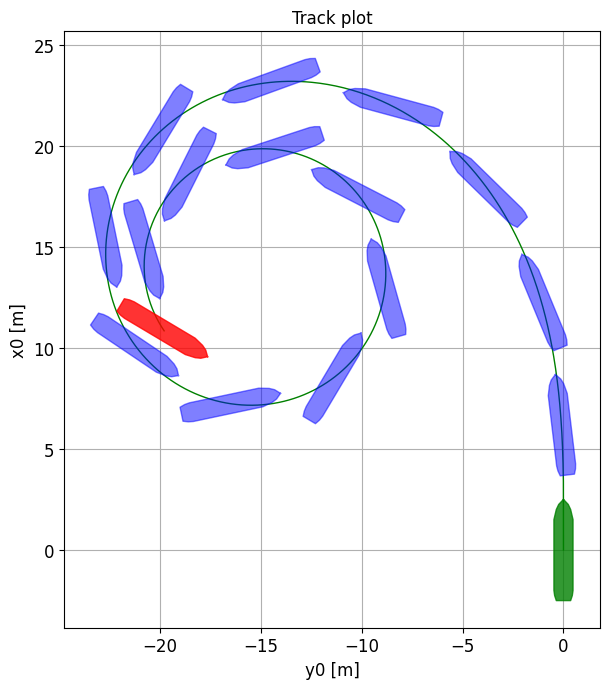

In [24]:
result.track_plot();

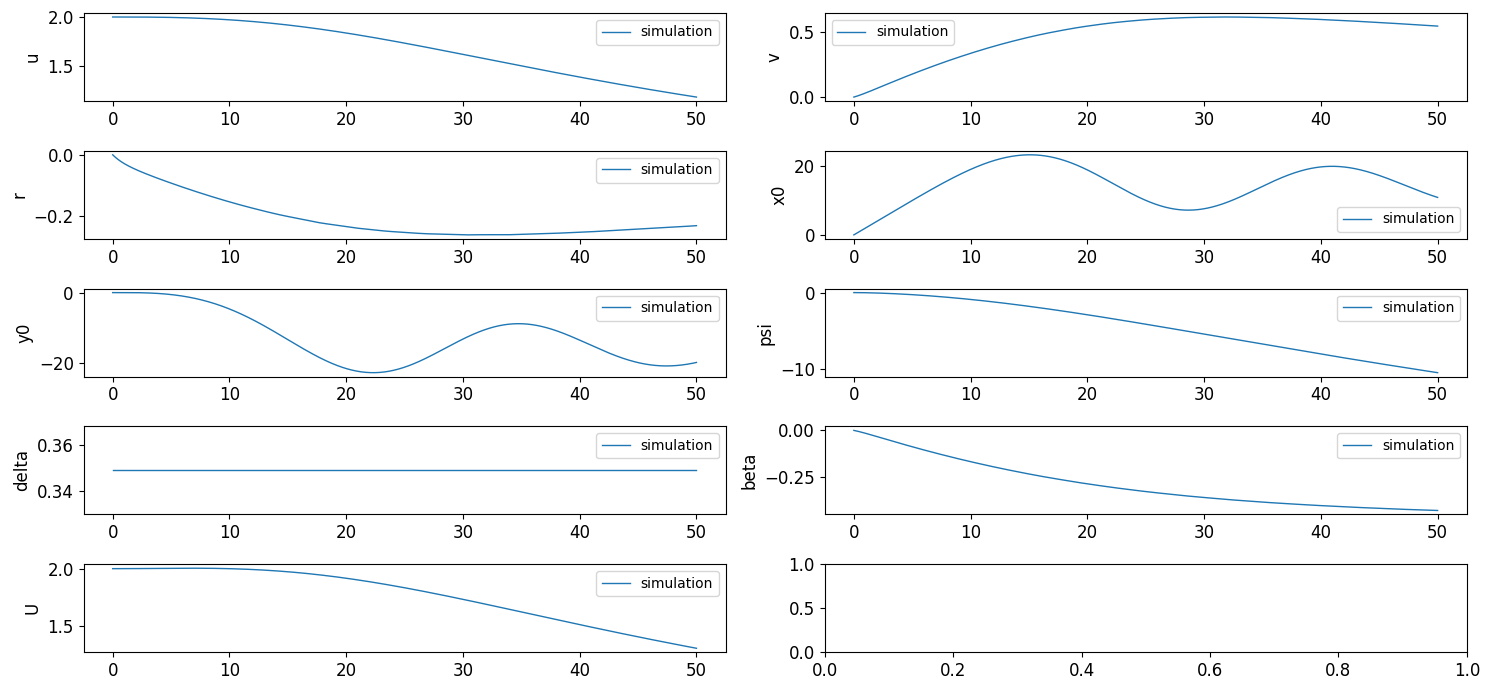

In [39]:
fig = result.plot()
plt.tight_layout()

### Simulate parameter contributions

In [26]:
df_result_prime = ps.prime(result.result, U=result.result['U'])

In [27]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=vmm.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r])
X = diff_eq_X.calculate_features(data=df_result_prime)
X_parameters = df_parameters.groupby(by='dof').get_group('X')['prime'].dropna()
X_forces = X*X_parameters
X_forces.index = df_result_prime.index

Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=vmm.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])
X = diff_eq_Y.calculate_features(data=df_result_prime)
Y_parameters = df_parameters.groupby(by='dof').get_group('Y')['prime'].dropna()
Y_forces = X*Y_parameters
Y_forces.index = df_result_prime.index

N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=vmm.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])
X = diff_eq_N.calculate_features(data=df_result_prime)
N_parameters = df_parameters.groupby(by='dof').get_group('N')['prime'].dropna()
N_forces = X*N_parameters
N_forces.index = df_result_prime.index

Here is an interavtive graph showing how the various hydrodynamic derivatives contribute to the forces:

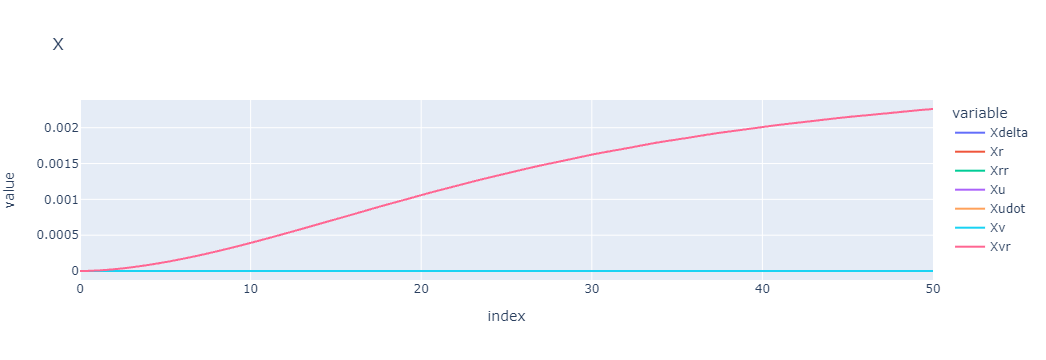

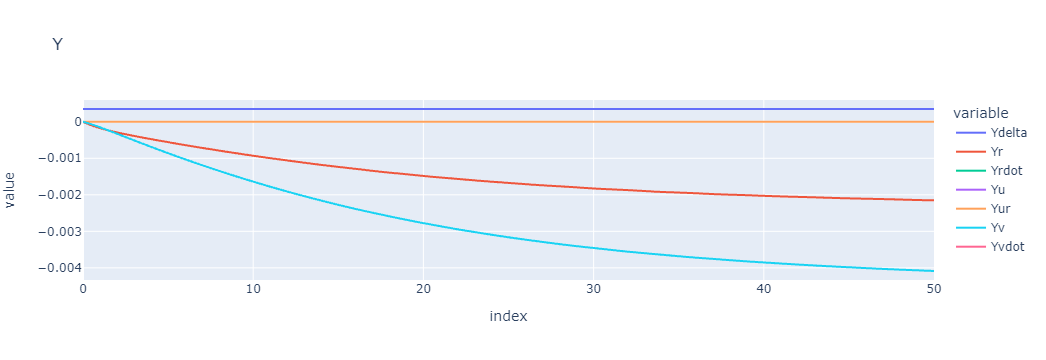

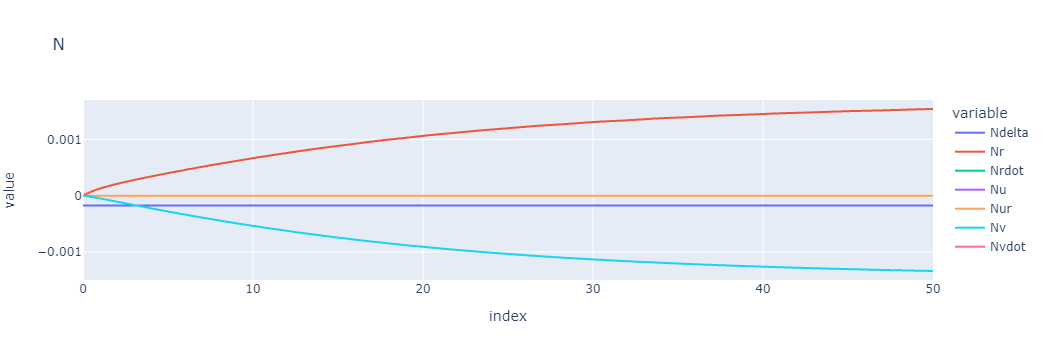

In [48]:
display(px.line(X_forces, y=X_forces.columns, width=800, height=350, title='X'))
display(px.line(Y_forces, y=Y_forces.columns, width=800, height=350, title='Y'))
display(px.line(N_forces, y=N_forces.columns, width=800, height=350, title='N'))